In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import re

from sklearn.metrics import log_loss, accuracy_score

from collections import defaultdict

import ast

from scipy.stats import wilcoxon, ttest_rel
from adjustText import adjust_text
import glob

# Create scatter plot with accuracies

In [33]:
TECHNIQUE = 'lr'

datasets = [
    'Adiac',
    'Beef',
    'BeetleFly',
    'BirdChicken',
    'ChlorineConcentration',
    'Coffee',
    'ECGFiveDays',
    'FaceFour',
    'GunPoint',
    'ItalyPowerDemand',
    'Lightning7',
    'MedicalImages',
    'MoteStrain',
    'SonyAIBORobotSurface1',
    'SonyAIBORobotSurface2',
    'Symbols',
    'SyntheticControl',
    'Trace',
    'TwoLeadECG'
]

learned_accuracies = defaultdict(list)
genetic_accuracies = defaultdict(list)

for dataset in datasets:
    
    ground_truth = pd.read_csv('../data/partitioned/{}/{}_test.csv'.format(dataset, dataset))['target']
    map_dict = {}
    for j, c in enumerate(np.unique(ground_truth)):
        map_dict[c] = j
    ground_truth = ground_truth.map(map_dict) 
    
    prediction_files = glob.glob('lts_vs_genetic/{}_learned_shapelets_predictions_*_{}_hard.csv'.format(dataset, TECHNIQUE))
    for f in prediction_files:
        pred_df = pd.read_csv(f)['prediction']
        learned_accuracies[dataset].append(accuracy_score(ground_truth, pred_df))
    
    prediction_files = glob.glob('lts_vs_genetic/{}_genetic_shapelets_predictions_*_{}_hard.csv'.format(dataset, TECHNIQUE))
    for f in prediction_files:
        pred_df = pd.read_csv(f)['prediction']
        genetic_accuracies[dataset].append(accuracy_score(ground_truth, pred_df))

In [34]:
names = []
genetic_accs = []
learning_accs = []
p_values = []

for dataset in learned_accuracies:
    if len(learned_accuracies[dataset]) < len(genetic_accuracies[dataset]):
        genetic_accuracies[dataset] = np.random.choice(genetic_accuracies[dataset], size=len(learned_accuracies[dataset]))
        
    if len(learned_accuracies[dataset]) > len(genetic_accuracies[dataset]):
        learned_accuracies[dataset] = np.random.choice(learned_accuracies[dataset], size=len(genetic_accuracies[dataset]))
    
    avg_learn_acc = np.mean(learned_accuracies[dataset])
    avg_genetic_acc = np.mean(genetic_accuracies[dataset])
    names.append(dataset)
    genetic_accs.append(avg_genetic_acc)
    learning_accs.append(avg_learn_acc)
    p_val = wilcoxon(learned_accuracies[dataset], genetic_accuracies[dataset])[1]
    print('[{}] Measurements = {}'.format(dataset, len(learned_accuracies[dataset])))
    p_values.append(p_val)
    
p_values = np.array(p_values)
genetic_accs = np.array(genetic_accs)
learning_accs = np.array(learning_accs)

print(np.mean(genetic_accs), np.mean(learning_accs))
print(wilcoxon(genetic_accs, learning_accs))

[Adiac] Measurements = 15
[Beef] Measurements = 15
[BeetleFly] Measurements = 15
[BirdChicken] Measurements = 15
[ChlorineConcentration] Measurements = 15
[Coffee] Measurements = 16
[ECGFiveDays] Measurements = 15
[FaceFour] Measurements = 16
[GunPoint] Measurements = 15
[ItalyPowerDemand] Measurements = 15
[Lightning7] Measurements = 15
[MedicalImages] Measurements = 15
[MoteStrain] Measurements = 15
[SonyAIBORobotSurface1] Measurements = 15
[SonyAIBORobotSurface2] Measurements = 15
[Symbols] Measurements = 15
[SyntheticControl] Measurements = 16
[Trace] Measurements = 15
[TwoLeadECG] Measurements = 15
0.8393167153772625 0.8302386534154244
WilcoxonResult(statistic=92.0, pvalue=0.9039076325167246)


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


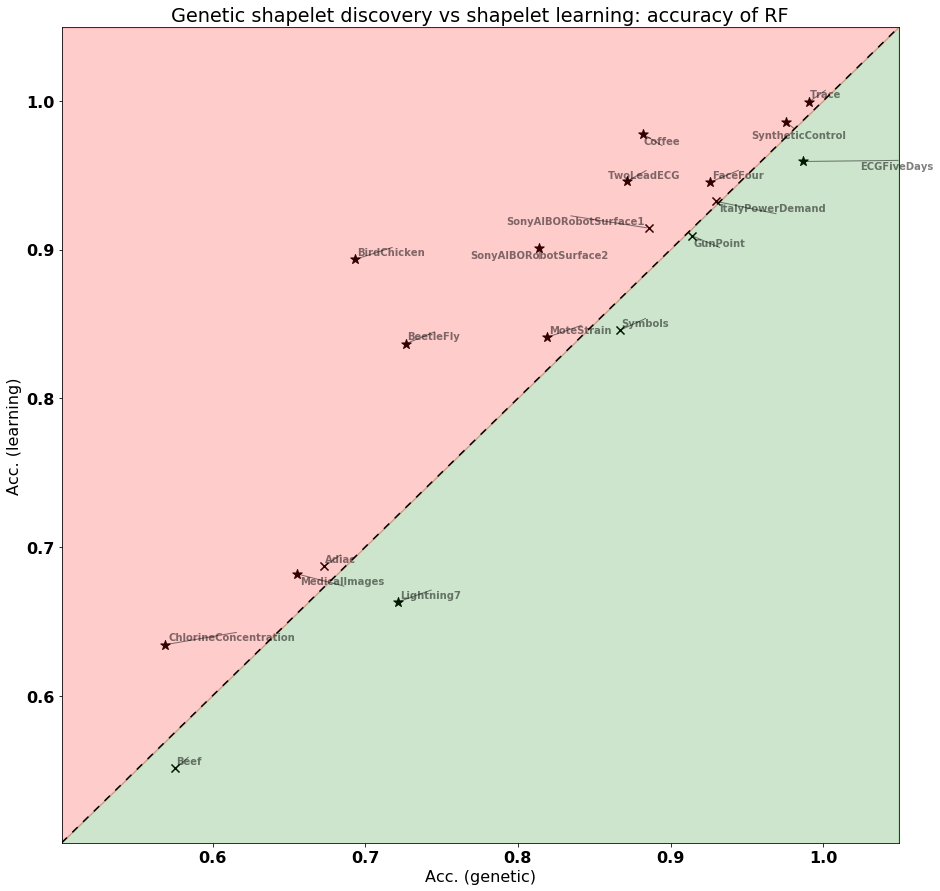

In [13]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

plt.figure(figsize=(15,15))

plt.scatter(genetic_accs[p_values <= 0.05], learning_accs[p_values <= 0.05], c='k', marker='*', s=100)
plt.scatter(genetic_accs[p_values > 0.05], learning_accs[p_values > 0.05], c='k', marker='x', s=65)

limits = [np.min(np.append(genetic_accs, learning_accs)) - 0.05, np.max(np.append(genetic_accs, learning_accs)) + 0.05]
f = lambda x: x
range_x = np.linspace(limits[0], limits[1], 100)

plt.plot(range_x, f(range_x), dashes=[5,5], c='k')

plt.fill_between(range_x, f(range_x), alpha=0.2, color='g')
plt.fill_between(range_x, f(range_x), limits[1], alpha=0.2, color='r')

texts = []
for name, x, y in zip(names, genetic_accs, learning_accs):
    texts.append(plt.annotate(name, (x, y), fontsize=10, alpha=0.5))

adjust_text(texts, only_move={'text': 'xy'}, arrowprops=dict(arrowstyle="-", color='k', lw=1.0, alpha=0.5))
    
plt.xlim(limits)
plt.ylim(limits)

plt.xlabel('Acc. (genetic)')
plt.ylabel('Acc. (learning)')

plt.title('Genetic shapelet discovery vs shapelet learning: accuracy of {}'.format(TECHNIQUE.upper()))

plt.savefig('gen_vs_lts_{}_accuracy.svg'.format(TECHNIQUE))

plt.show()

# Scatter plot with loglosses

In [39]:
TECHNIQUE = 'lr'

datasets = [
    'Adiac',
    'Beef',
    'BeetleFly',
    'BirdChicken',
    'ChlorineConcentration',
    'Coffee',
    'ECGFiveDays',
    'FaceFour',
    'GunPoint',
    'ItalyPowerDemand',
    'Lightning7',
    'MedicalImages',
    'MoteStrain',
    'SonyAIBORobotSurface1',
    'SonyAIBORobotSurface2',
    'Symbols',
    'SyntheticControl',
    'Trace',
    'TwoLeadECG'
]

learned_loglosses = defaultdict(list)
genetic_loglosses = defaultdict(list)

for dataset in datasets:
    
    ground_truth = pd.read_csv('../data/partitioned/{}/{}_test.csv'.format(dataset, dataset))['target']
    map_dict = {}
    for j, c in enumerate(np.unique(ground_truth)):
        map_dict[c] = j
    ground_truth = ground_truth.map(map_dict) 
    
    prediction_files = glob.glob('lts_vs_genetic/{}_learned_shapelets_predictions_*_{}_proba.csv'.format(dataset, TECHNIQUE))
    print(dataset, len(prediction_files))
    for f in prediction_files:
        pred_df = pd.read_csv(f)
        pred_df = pred_df.drop('Unnamed: 0', axis=1)
        learned_loglosses[dataset].append(log_loss(ground_truth, pred_df))
    
    prediction_files = glob.glob('lts_vs_genetic/{}_genetic_shapelets_predictions_*_{}_proba.csv'.format(dataset, TECHNIQUE))
    print(dataset, len(prediction_files))
    for f in prediction_files:
        pred_df = pd.read_csv(f)
        pred_df = pred_df.drop('Unnamed: 0', axis=1)
        genetic_loglosses[dataset].append(log_loss(ground_truth, pred_df))

Adiac 15
Adiac 15
Beef 15
Beef 15
BeetleFly 15
BeetleFly 15
BirdChicken 15
BirdChicken 15
ChlorineConcentration 15
ChlorineConcentration 15
Coffee 16
Coffee 16
ECGFiveDays 15
ECGFiveDays 15
FaceFour 16
FaceFour 16
GunPoint 15
GunPoint 15
ItalyPowerDemand 15
ItalyPowerDemand 15
Lightning7 15
Lightning7 15
MedicalImages 15
MedicalImages 15
MoteStrain 15
MoteStrain 15
SonyAIBORobotSurface1 15
SonyAIBORobotSurface1 15
SonyAIBORobotSurface2 15
SonyAIBORobotSurface2 15
Symbols 16
Symbols 15
SyntheticControl 16
SyntheticControl 16
Trace 15
Trace 15
TwoLeadECG 15
TwoLeadECG 15


In [40]:
names = []
genetic_lls = []
learning_lls = []
p_values = []

for dataset in datasets:
    if len(learned_loglosses[dataset]) < len(genetic_loglosses[dataset]):
        genetic_loglosses[dataset] = np.random.choice(genetic_loglosses[dataset], size=len(learned_loglosses[dataset]))
        
    if len(learned_loglosses[dataset]) > len(genetic_loglosses[dataset]):
        learned_loglosses[dataset] = np.random.choice(genetic_loglosses[dataset], size=len(genetic_loglosses[dataset]))
    
    avg_learn_ll = np.mean(learned_loglosses[dataset])
    avg_genetic_ll = np.mean(genetic_loglosses[dataset])
    print('[{}] LTS LL = {} || Gen LL = {}'.format(dataset, avg_learn_ll, avg_genetic_ll))
    
    names.append(dataset)
    genetic_lls.append(avg_genetic_ll)
    learning_lls.append(avg_learn_ll)
    p_values.append(wilcoxon(learned_loglosses[dataset], genetic_loglosses[dataset])[1])
    
p_values = np.array(p_values)
genetic_lls = np.array(genetic_lls)
learning_lls = np.array(learning_lls)

print(np.mean(genetic_lls), np.mean(learning_lls))
print(wilcoxon(genetic_lls, learning_lls))

[Adiac] LTS LL = 2.3335705355855962 || Gen LL = 1.308468185524514
[Beef] LTS LL = 1.1796027422390922 || Gen LL = 0.9448765095718824
[BeetleFly] LTS LL = 0.642408048791668 || Gen LL = 0.5827927431583625
[BirdChicken] LTS LL = 0.5257091046356498 || Gen LL = 0.5042426287085974
[ChlorineConcentration] LTS LL = 0.8967279631966326 || Gen LL = 0.9684743130866892
[Coffee] LTS LL = 0.5690245707648034 || Gen LL = 0.56554515629289
[ECGFiveDays] LTS LL = 0.2242866698734601 || Gen LL = 0.3144295827764001
[FaceFour] LTS LL = 0.21732322837321977 || Gen LL = 0.38446246096801906
[GunPoint] LTS LL = 0.18138602425725486 || Gen LL = 0.1500036308413438
[ItalyPowerDemand] LTS LL = 0.4221747614689938 || Gen LL = 0.3397932660959038
[Lightning7] LTS LL = 0.9208402506792801 || Gen LL = 0.9303956343380801
[MedicalImages] LTS LL = 0.8340395324190746 || Gen LL = 1.0156673807421923
[MoteStrain] LTS LL = 0.446308702555306 || Gen LL = 0.48526823577591843
[SonyAIBORobotSurface1] LTS LL = 0.384240604662092 || Gen LL = 

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


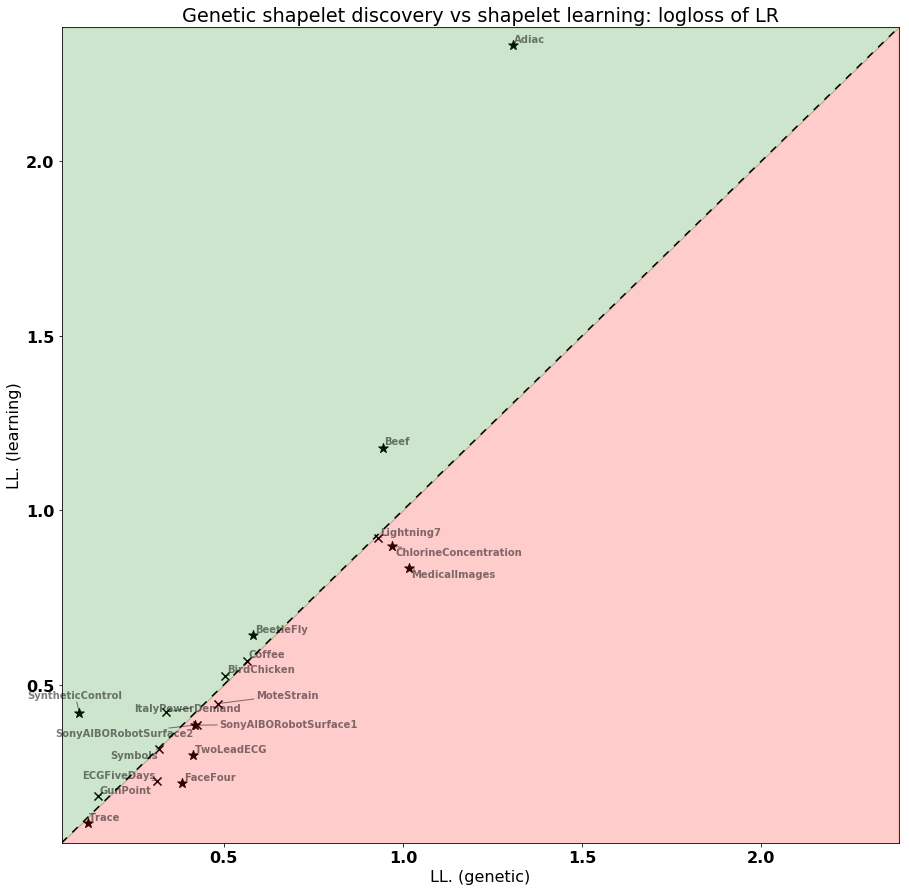

In [32]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

plt.figure(figsize=(15,15))

plt.scatter(genetic_lls[p_values <= 0.05], learning_lls[p_values <= 0.05], c='k', marker='*', s=100)
plt.scatter(genetic_lls[p_values > 0.05], learning_lls[p_values > 0.05], c='k', marker='x', s=65)

limits = [np.min(np.append(genetic_lls, learning_lls)) - 0.05, np.max(np.append(genetic_lls, learning_lls)) + 0.05]
f = lambda x: x
range_x = np.linspace(limits[0], limits[1], 100)

plt.plot(range_x, f(range_x), dashes=[5,5], c='k')

plt.fill_between(range_x, f(range_x), alpha=0.2, color='r')
plt.fill_between(range_x, f(range_x), limits[1], alpha=0.2, color='g')

texts = []
for name, x, y in zip(names, genetic_lls, learning_lls):
    texts.append(plt.annotate(name, (x, y), fontsize=10, alpha=0.5))

adjust_text(texts, only_move={'text': 'xy'}, arrowprops=dict(arrowstyle="-", color='k', lw=1.0, alpha=0.5))
    
plt.xlim(limits)
plt.ylim(limits)

plt.xlabel('LL. (genetic)')
plt.ylabel('LL. (learning)')

plt.title('Genetic shapelet discovery vs shapelet learning: logloss of {}'.format(TECHNIQUE.upper()))

plt.savefig('gen_vs_lts_{}_logloss.svg'.format(TECHNIQUE))

plt.show()

# Compare interpretability of discovered shapelets of both techniques

In [29]:
import sys
sys.path.append('..')
import util

def visualize_shapelet(timeseries, labels, shapelets):
    """Create a visualization by taking a few sample
    timeseries per class and then creating line graphs
    with both the timeseries and the shapelets (aligned
    at its best location)"""
    timeseries_per_class = defaultdict(list)
    unique_classes = set(labels)

    for ts, label in zip(timeseries, labels):
        timeseries_per_class[label].append(ts)

    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'w'] * 2
    
    samples_per_class = {}
    for c in timeseries_per_class:
        rand_idx = np.random.choice(range(len(timeseries_per_class[c])), replace=False, size=5)
        samples_per_class[c] = np.array(timeseries_per_class[c])[rand_idx]
        
    plt.figure(figsize=(12, 6))
    for i, c in enumerate(unique_classes):
        for j, ts in enumerate(samples_per_class[c]):
            plt.plot(range(len(ts)), ts, c=colors[i], lw=3)
    
    for shap in shapelets:
        # TODO: This is wrong... We are measuring dist to last ts from previous for-loop
        dist, pos = util.sdist_with_pos(shap, ts)
        plt.plot(range(pos, pos+len(shap)), shap, c='k')
        
    plt.show()
    
def parse_shapelets(shapelets):
    shapelets = shapelets.replace(']', '],')[:-2]
    shapelets = re.sub(r'\s+', ', ', shapelets)
    shapelets = re.sub(r',+', ',', shapelets)
    shapelets = shapelets.replace('],[', '], [')
    shapelets = shapelets.replace('[,', '[')
    shapelets = '[' + shapelets + ']'
    shapelets = re.sub(r',\s+]', ']', shapelets)
    return ast.literal_eval(shapelets)

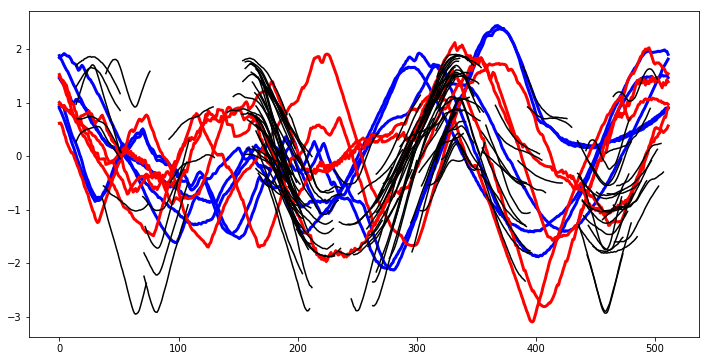

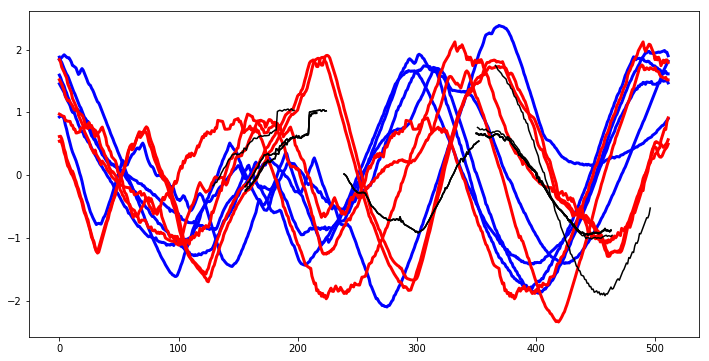

(38, 131)

In [30]:
genetic_shapelets = open('lts_vs_genetic/BirdChicken_genetic_shapelets_1531408731.txt', 'r').read()
learned_shapelets = open('lts_vs_genetic/BirdChicken_learned_shapelets_1531406937.txt', 'r').read()
data = pd.read_csv('../data/partitioned/BirdChicken/BirdChicken_test.csv')
timeseries = data.drop('target', axis=1).values
target = data['target']

genetic_shapelets = parse_shapelets(genetic_shapelets)
learned_shapelets = parse_shapelets(learned_shapelets)

visualize_shapelet(timeseries, target, learned_shapelets)

visualize_shapelet(timeseries, target, genetic_shapelets)

max([len(x) for x in learned_shapelets]), max([len(x) for x in genetic_shapelets])

In [ ]:
genetic_shapelets = open('lts_vs_genetic/Coffee_genetic_shapelets_1531377162.txt', 'r').read()
learned_shapelets = open('lts_vs_genetic/Coffee_learned_shapelets_1531376798.txt', 'r').read()
data = pd.read_csv('../data/partitioned/Coffee/Coffee_test.csv')
timeseries = data.drop('target', axis=1).values
target = data['target']

genetic_shapelets = parse_shapelets(genetic_shapelets)
learned_shapelets = parse_shapelets(learned_shapelets)

visualize_shapelet(timeseries, target, learned_shapelets)

visualize_shapelet(timeseries, target, genetic_shapelets)

max([len(x) for x in learned_shapelets]), max([len(x) for x in genetic_shapelets])

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


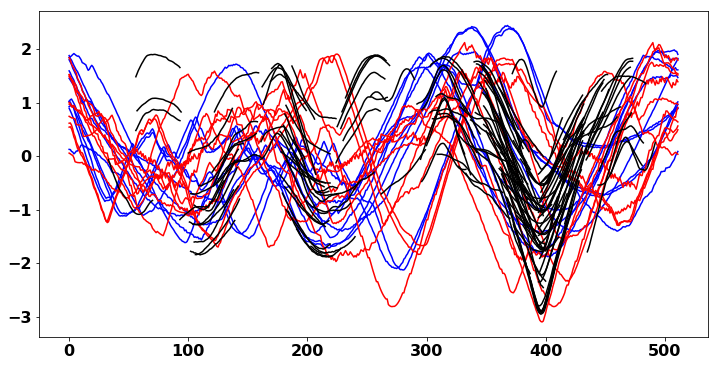

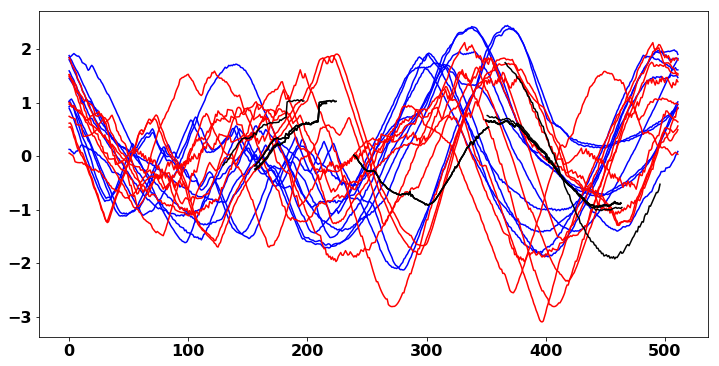

(38, 131)

In [76]:
genetic_shapelets = open('lts_vs_genetic/BirdChicken_genetic_shapelets_1531408731.txt', 'r').read()
learned_shapelets = open('lts_vs_genetic/BirdChicken_learned_shapelets_1531406937.txt', 'r').read()
data = pd.read_csv('../data/partitioned/BirdChicken/BirdChicken_test.csv')
timeseries = data.drop('target', axis=1).values
target = data['target']

genetic_shapelets = parse_shapelets(genetic_shapelets)
learned_shapelets = parse_shapelets(learned_shapelets)

visualize_shapelet(timeseries, target, learned_shapelets)

visualize_shapelet(timeseries, target, genetic_shapelets)

max([len(x) for x in learned_shapelets]), max([len(x) for x in genetic_shapelets])

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


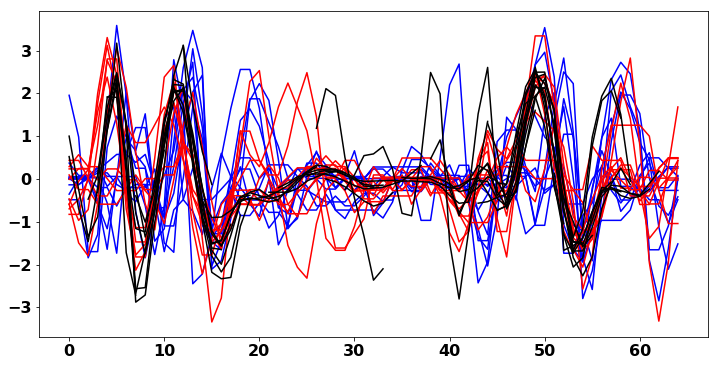

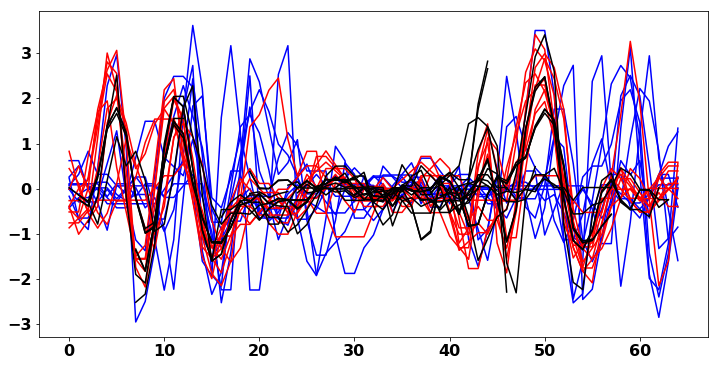

(16, 63)

In [77]:
genetic_shapelets = open('lts_vs_genetic/SonyAIBORobotSurface2_genetic_shapelets_1531232099.txt', 'r').read()
learned_shapelets = open('lts_vs_genetic/SonyAIBORobotSurface2_learned_shapelets_1531231793.txt', 'r').read()
data = pd.read_csv('../data/partitioned/SonyAIBORobotSurface2/SonyAIBORobotSurface2_test.csv')
timeseries = data.drop('target', axis=1).values
target = data['target']

genetic_shapelets = parse_shapelets(genetic_shapelets)
learned_shapelets = parse_shapelets(learned_shapelets)

visualize_shapelet(timeseries, target, learned_shapelets)

visualize_shapelet(timeseries, target, genetic_shapelets)

max([len(x) for x in learned_shapelets]), max([len(x) for x in genetic_shapelets])